# $SiC$ Irradiation Calcualtions

**requires python >= 3.5** 

These calculations we done for a [publication Coupled electronic and atomic effects on defect evolution in silicon carbide under ion irradiation](https://doi.org/10.1016/j.cossms.2017.09.003)

This details just how much information can be processed with the `COLLISON.txt` file.

In total 10,000 ions were done for 5 different ions in the publication. Totalling about 72 hours of calcuations. Without the automation of Python this would not be a fun task. This tutorial has been shortened so that we only simulate 100 ions. But you **should** use more ions when publishing.

This tutorial will take a total of about 10-15 minutes.

In [1]:
%matplotlib inline

import os
from collections import Counter
from itertools import count
from random import randint
from pathlib import Path
import math

# Only needed to embed the images in notebook so they
# show up in gitlab repo
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde
import seaborn

from srim import TRIM, Target, Layer, Ion, Element

# directory to srim executable (must be SRIM 2013)
SRIM_EXECUTABLE_DIRECTORY = os.path.abspath('/tmp/srim')
# directory to store srim output (does not have to exist)
DATA_DIRECTORY = os.path.abspath('/tmp/outputs')
# directory to store images from processing srim output (does not have to exist)
IMAGE_DIRECTORY = os.path.abspath('../images')

os.makedirs(DATA_DIRECTORY, exist_ok=True)
os.makedirs(IMAGE_DIRECTORY, exist_ok=True)

The directory structure that SRIM calculations will be stored in.

```
DATA_DIRECTORY/
 - C/
    - 0/
    - 1/
    - 2/
 - O/
    - 0/
    - 1/
 - Si/
    - 0/
  ...
```

# C, O, Si, Ni and Au in SiC 

Here are the detail requirements for the calculations and plots:

 - Ions:  4.5 MeV C, 6.5 MeV O, 21 MeV Si, 21 MeV Ni, and 25 MeV Au
 - Target: SiC, density of SiC is 3.21 g cm-3. The threshold displacement energy is taken to be 35 and 20 eV for Si and C sublattice, respectively.
 - Plots: ideally 3 plots for each ion-SiC combination (XY plane, XZ plane and YZ plane) from 0 to 1000 nm. It may also work for the purpose in the manuscript if you can plot for a narrower depth, for example from 450 nm to 550 nm.
 - No need to plot anything deeper than 1000 nm.

Please try to plot the cases for 21 MeV Si and 25 MeV Au, and send me to have a look (so we can finalize) before spending too much time.

In [2]:
# Define calculations in code
ions = [
    {'identifier': 'Au', 'energy': 25.0e6}, # eV
    {'identifier': 'C', 'energy': 4.5e6}, # eV
    {'identifier': 'O', 'energy': 6.5e6}, # eV
    {'identifier': 'Si', 'energy': 21.0e6}, # eV
    {'identifier': 'Ni', 'energy': 21.0e6}, # eV
]

layer = Layer({
    'Si': {
        'stoich': 0.5,
        'E_d': 35.0, # Displacement Energy
        'lattice': 0.0,
        'surface': 3.0
    },
    'C': {
        'stoich': 0.5,
        'E_d': 20.0, # Displacement Energy
        'lattice': 0.0,
        'surface': 3.0
    }
}, density=3.21, width=10000.0)
target = Target([layer])

# number of ions to use in each SRIM calculation
# allows for fragmentation of calcluation
# step size should never be larger than 1,000
# if you are storing COLLISON.txt
IONS_PER_STEP = 20
# number of ions to simulate for each ion
NUM_IONS = 100

# See TRIMSettings and TRIM for full options
# you can do any setting that you could do in TRIM
TRIM_SETTINGS = {
    'calculation': 2, # full cascade
    'collisions': 2,
    # 'angle_ions': 30
}

In [3]:
# Helper functions to run calculations
def fragment(step, total):
    remaining = total
    while remaining > 0:
        if step > remaining:
            return remaining
        else:
            remaining -= step
            yield step
            
def find_folder(directory):
    for i in count():
        path = Path(directory) / str(i)
        if not path.is_dir():
            return str(path.absolute())

def run_fragmented_calculation(ion, target, number_ions, path, trim_settings, step):
    for i, num_ions in enumerate(fragment(step, number_ions)):
        print('total ions completed: {:06d}\tion: {}\tions in step: {:06d}'.format(i*step, ion.symbol, num_ions))
        trim_settings = trim_settings or {'calculation': 2}
        trim = TRIM(target, ion, number_ions=num_ions, **trim_settings)
        results = trim.run(SRIM_EXECUTABLE_DIRECTORY)
        save_directory = find_folder(path)
        print('calculation saved to:', save_directory)
        os.makedirs(save_directory, exist_ok=True)
        TRIM.copy_output_files(SRIM_EXECUTABLE_DIRECTORY, save_directory)

# Running TRIM in fragments

TRIM has a tendancy to crash so the above wrapper functions run a TRIM calcualtion in `steps` of size 1,000 ions - 10,000 total.

In addition it runs these many calculations in batch and write the output folders in this structure
```
 - Au/
    - 0/
    - 1/
    - 2/
 - Ni/
    - 0/
    - 1/
```

In [4]:
# Run SRIM calcluations for each ion
for ion in ions:
    symbol_path = os.path.join(DATA_DIRECTORY, ion['identifier'])
    run_fragmented_calculation(Ion(**ion), target, NUM_IONS, symbol_path, TRIM_SETTINGS, step=IONS_PER_STEP)

total ions completed: 000000	ion: Au	ions in step: 000020
calculation saved to: /tmp/outputs/Au/0
total ions completed: 000020	ion: Au	ions in step: 000020
calculation saved to: /tmp/outputs/Au/1
total ions completed: 000040	ion: Au	ions in step: 000020
calculation saved to: /tmp/outputs/Au/2
total ions completed: 000060	ion: Au	ions in step: 000020
calculation saved to: /tmp/outputs/Au/3
total ions completed: 000080	ion: Au	ions in step: 000020
calculation saved to: /tmp/outputs/Au/4
total ions completed: 000000	ion: C	ions in step: 000020
calculation saved to: /tmp/outputs/C/0
total ions completed: 000020	ion: C	ions in step: 000020
calculation saved to: /tmp/outputs/C/1
total ions completed: 000040	ion: C	ions in step: 000020
calculation saved to: /tmp/outputs/C/2
total ions completed: 000060	ion: C	ions in step: 000020
calculation saved to: /tmp/outputs/C/3
total ions completed: 000080	ion: C	ions in step: 000020
calculation saved to: /tmp/outputs/C/4
total ions completed: 000000	i

# Analysis

We are going to plot the collisions from ions and recoil atoms. The COLLISON.txt file can get huge.

 - Read Collisions.txt
 - Plot heatmap of yz plane
 - Radial distribution of yz plane about center (0, 0)

In [5]:
# Helper functions
def parse_directory(dir):
    """ Parse directory with expected structure <dir>/<ion_symbol>/<int>/COLLISON.txt
    
    This functions will collect the position <x, y, z> of every ion and recoil collision.
    
    It will write to a numpy array the parsing. This file will be about 10% of the original
    """
    if not os.path.exists(os.path.join(dir, 'collision.dat.npy')):
        positions = []
        with open(os.path.join(dir, 'COLLISON.txt'), 'rb') as f:
            for line in f.readlines():
                line = line.decode('latin-1')
                if line.endswith('Start of New Cascade  ³\r\n'):
                    tokens = line.split(chr(179))[1:-1]
                    positions.append([float(tokens[2]), float(tokens[3]), float(tokens[4])])
                elif line.startswith('Û 0'):
                    tokens = line.split()[1:-1]
                    positions.append([float(tokens[3]), float(tokens[4]), float(tokens[5])])
        np.save(os.path.join(dir, 'collision.dat'), np.array(positions))

def plot_heatmap(ax, data, cols, limits, norm, bins=(1000, 200)):
    """ Plot a heatmap
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    cols : tuple
        tuple or list length 2. example (0, 2) x, z axis
    limits : tuple
        tuple or list (2x2) [[col[0] min, col[0] max], [col[0] min, col[0] max]]
    norm : mpl.colors
        colorbar scale to use
    """
    c1, c2 = cols
    (c1min, c1max), (c2min, c2max) = limits
    region_data = data[(data[:, c1] < c1max) & (data[:, c1] > c1min) & (data[:, c2] < c2max) & (data[:, c2] > c2min)]
    heatmap, xedges, yedges = np.histogram2d(region_data[:, c1], region_data[:, c2], range=limits, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap[heatmap == 0.0] = np.nan
    colormap = mpl.cm.get_cmap('viridis')
    return ax.imshow(heatmap.T, origin='lower', extent=extent, cmap=colormap, norm=norm)
    
def plot_radial_distribution_hist(ax, data, maximum, label):
    """ plot radial distribution of data
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    maximum : float
        maximum distance to plot radial distribution
    label : str
        label to give for plot
    """
    density, edges = np.histogram(data, bins=100, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-1, maximum, len(density))
    density = [d / (2 * math.pi * r)  for r, d in zip(x, density)]
    # return ax.plot(x, density, label=label)
    return ax.semilogy(x, density, label=label)
    
def plot_radial_distribution_kde(ax, data, maximum, label):
    """ Same as plot radial distribution of data except uses kde for smoothing"""
    x = np.linspace(0, maximum, 100)
    kde = gaussian_kde(np.concatenate((-data, data)))
    return ax.plot(x, kde.pdf(x), label=label)
    
sort_by_mass = lambda e1: Element(e1).mass

Read all SRIM Calculations and parse COLLISON.txt to produce numpy arrary this will traverse directory structure and create numpy data arrays in each folder

In [6]:
for dir in os.listdir(DATA_DIRECTORY):
    calculation_data = []
    total_ions = 0
    abs_dir_path = os.path.join(DATA_DIRECTORY, dir)
    if os.path.isdir(abs_dir_path):
        for calculation in os.listdir(abs_dir_path):
            if set(calculation) < set('0123456789') and os.path.isdir(os.path.join(abs_dir_path, calculation)): # check that dir only contains numbers
                parse_directory(os.path.join(abs_dir_path, calculation))
                print('parsed', os.path.join(abs_dir_path, calculation))

parsed /tmp/outputs/Au/0
parsed /tmp/outputs/Au/4
parsed /tmp/outputs/Au/2
parsed /tmp/outputs/Au/1
parsed /tmp/outputs/Au/3
parsed /tmp/outputs/Ni/0
parsed /tmp/outputs/Ni/4
parsed /tmp/outputs/Ni/2
parsed /tmp/outputs/Ni/1
parsed /tmp/outputs/Ni/3
parsed /tmp/outputs/O/0
parsed /tmp/outputs/O/4
parsed /tmp/outputs/O/2
parsed /tmp/outputs/O/1
parsed /tmp/outputs/O/3
parsed /tmp/outputs/C/0
parsed /tmp/outputs/C/4
parsed /tmp/outputs/C/2
parsed /tmp/outputs/C/1
parsed /tmp/outputs/C/3
parsed /tmp/outputs/Si/0
parsed /tmp/outputs/Si/4
parsed /tmp/outputs/Si/2
parsed /tmp/outputs/Si/1
parsed /tmp/outputs/Si/3


Combine all numpy array read from COLLISON.txt. This will take ALOT of RAM if NUM_IONS > 10,000 (4-6 Gb for me)

In [7]:
data = {}
for dir in os.listdir(DATA_DIRECTORY):
    collisions = []
    total_ions = 0
    if os.path.isdir(os.path.join(DATA_DIRECTORY, dir)):
        for calculation in os.listdir(os.path.join(DATA_DIRECTORY, dir)):
            with open(os.path.join(DATA_DIRECTORY, dir, calculation, 'TRIM.IN')) as f:
                num_ions = int(f.read().split('\n')[2].split()[-3])
            total_ions += num_ions
            collisions.append(np.load(os.path.join(DATA_DIRECTORY, dir, calculation, 'collision.dat.npy')))
        data[dir] = {'total_ions': total_ions, 'collisions': np.concatenate(collisions) / 10}

Print summary information about calculations and collisions

In [8]:
# print summary information
for ion in sorted(data, key=sort_by_mass):
    data_str = (
        "Symbol: {:2}\tNum Ions: {:7d}\tCollisions: {:7d}\n"
        "|\tMedian (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
        "|\tMean   (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
    )
    print(data_str.format(ion, data[ion]['total_ions'], len(data[ion]['collisions']), 
                          *np.median(data[ion]['collisions'], axis=0),
                          *np.mean(data[ion]['collisions'], axis=0)))

Symbol: C 	Num Ions:     100	Collisions:    4849
|	Median (x, y, z) [nm]: [595.100	-0.000	0.404]
|	Mean   (x, y, z) [nm]: [530.767	-6.701	5.961]

Symbol: O 	Num Ions:     100	Collisions:    8760
|	Median (x, y, z) [nm]: [541.850	-0.370	-0.721]
|	Mean   (x, y, z) [nm]: [536.481	-4.654	-6.433]

Symbol: Si	Num Ions:     100	Collisions:   10326
|	Median (x, y, z) [nm]: [567.750	-0.108	-0.002]
|	Mean   (x, y, z) [nm]: [539.544	-1.227	-1.480]

Symbol: Ni	Num Ions:     100	Collisions:   77288
|	Median (x, y, z) [nm]: [600.000	0.182	0.635]
|	Mean   (x, y, z) [nm]: [568.386	-5.405	23.101]

Symbol: Au	Num Ions:     100	Collisions:  667031
|	Median (x, y, z) [nm]: [522.600	0.250	0.189]
|	Mean   (x, y, z) [nm]: [517.901	4.090	0.778]



/home/costrouc/.virtualenvs/pysrim-QRHR1eEY/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


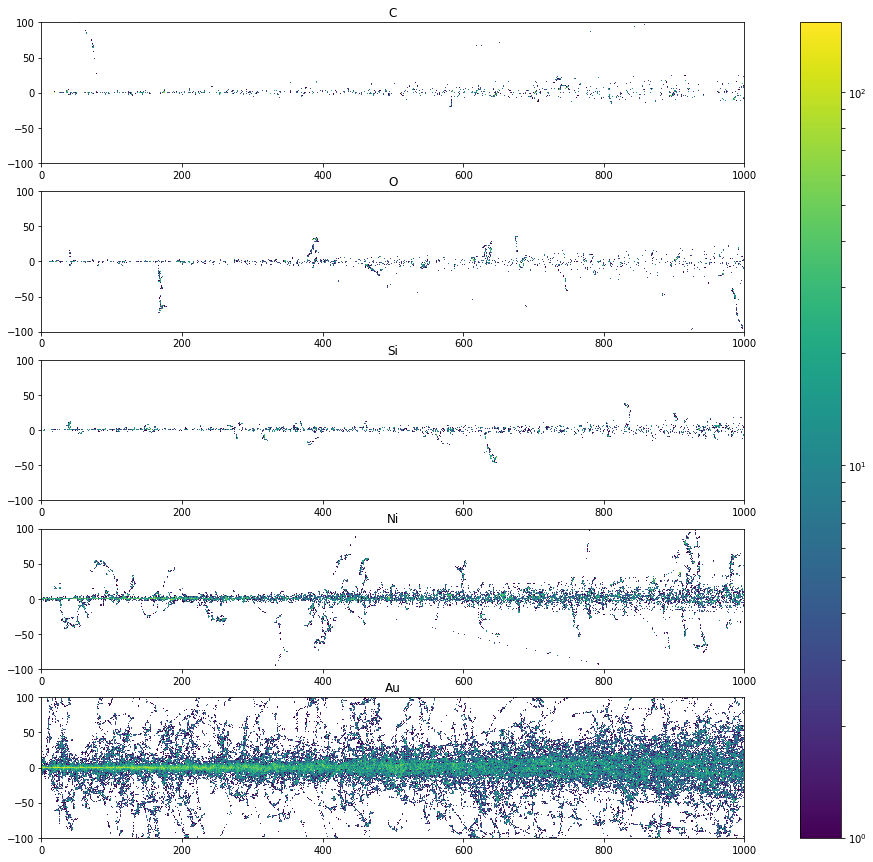

In [9]:
# Using Log color scale
limits = [[0, 1000], [-100, 100]]
bins = (1000, 200)

fig, axes = plt.subplots(len(ions), 1)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (0, 2), limits, norm, bins=bins)
    ax.set_title(ion)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 15)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-length-heatmap-log.png'), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

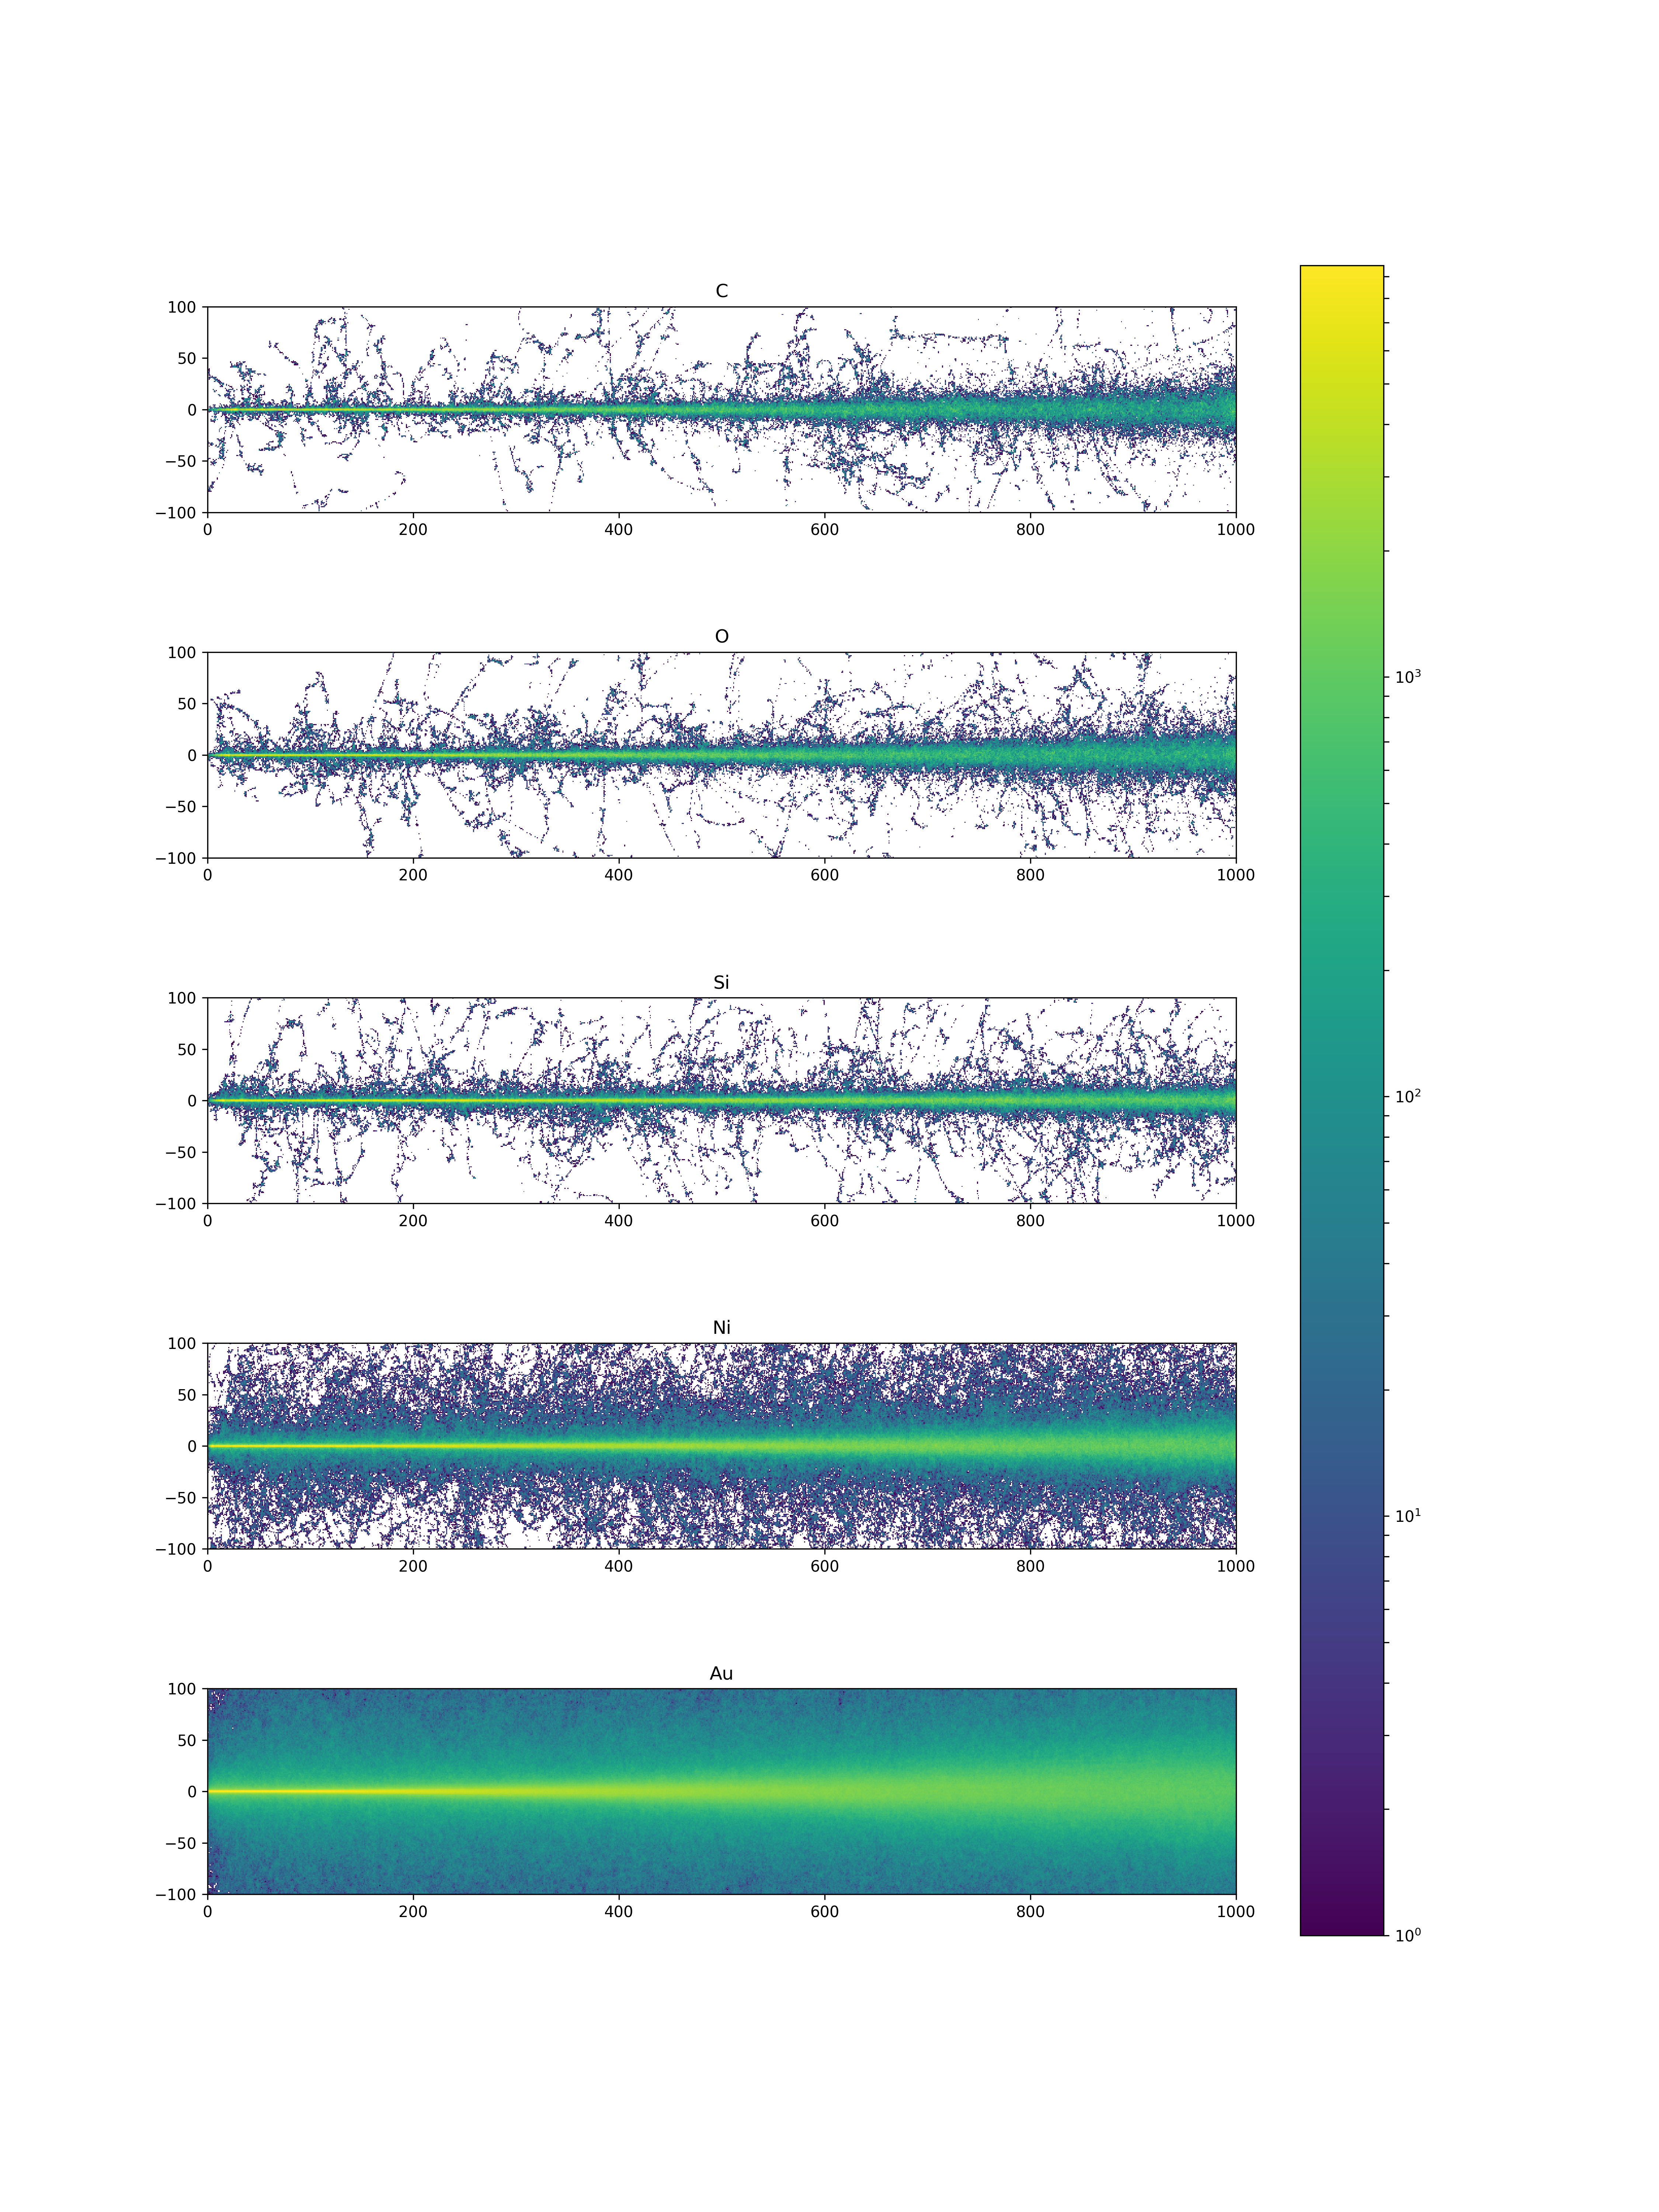

In [10]:
Image(filename=os.path.join(IMAGE_DIRECTORY, 'length-heatmap-log.png'))

/home/costrouc/.virtualenvs/pysrim-QRHR1eEY/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


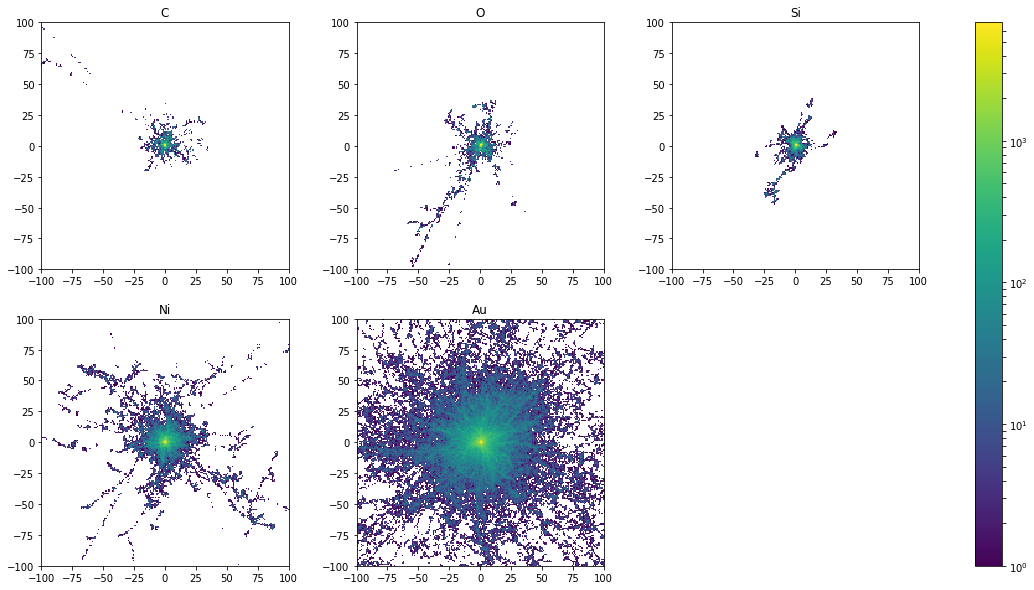

In [11]:
# Using Log color scale
limits = [[-100, 100], [-100, 100]]
bins = (200, 200)

fig, axes = plt.subplots(2, 3)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)
fig.delaxes(axes[1][2])
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 10)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log.png'), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

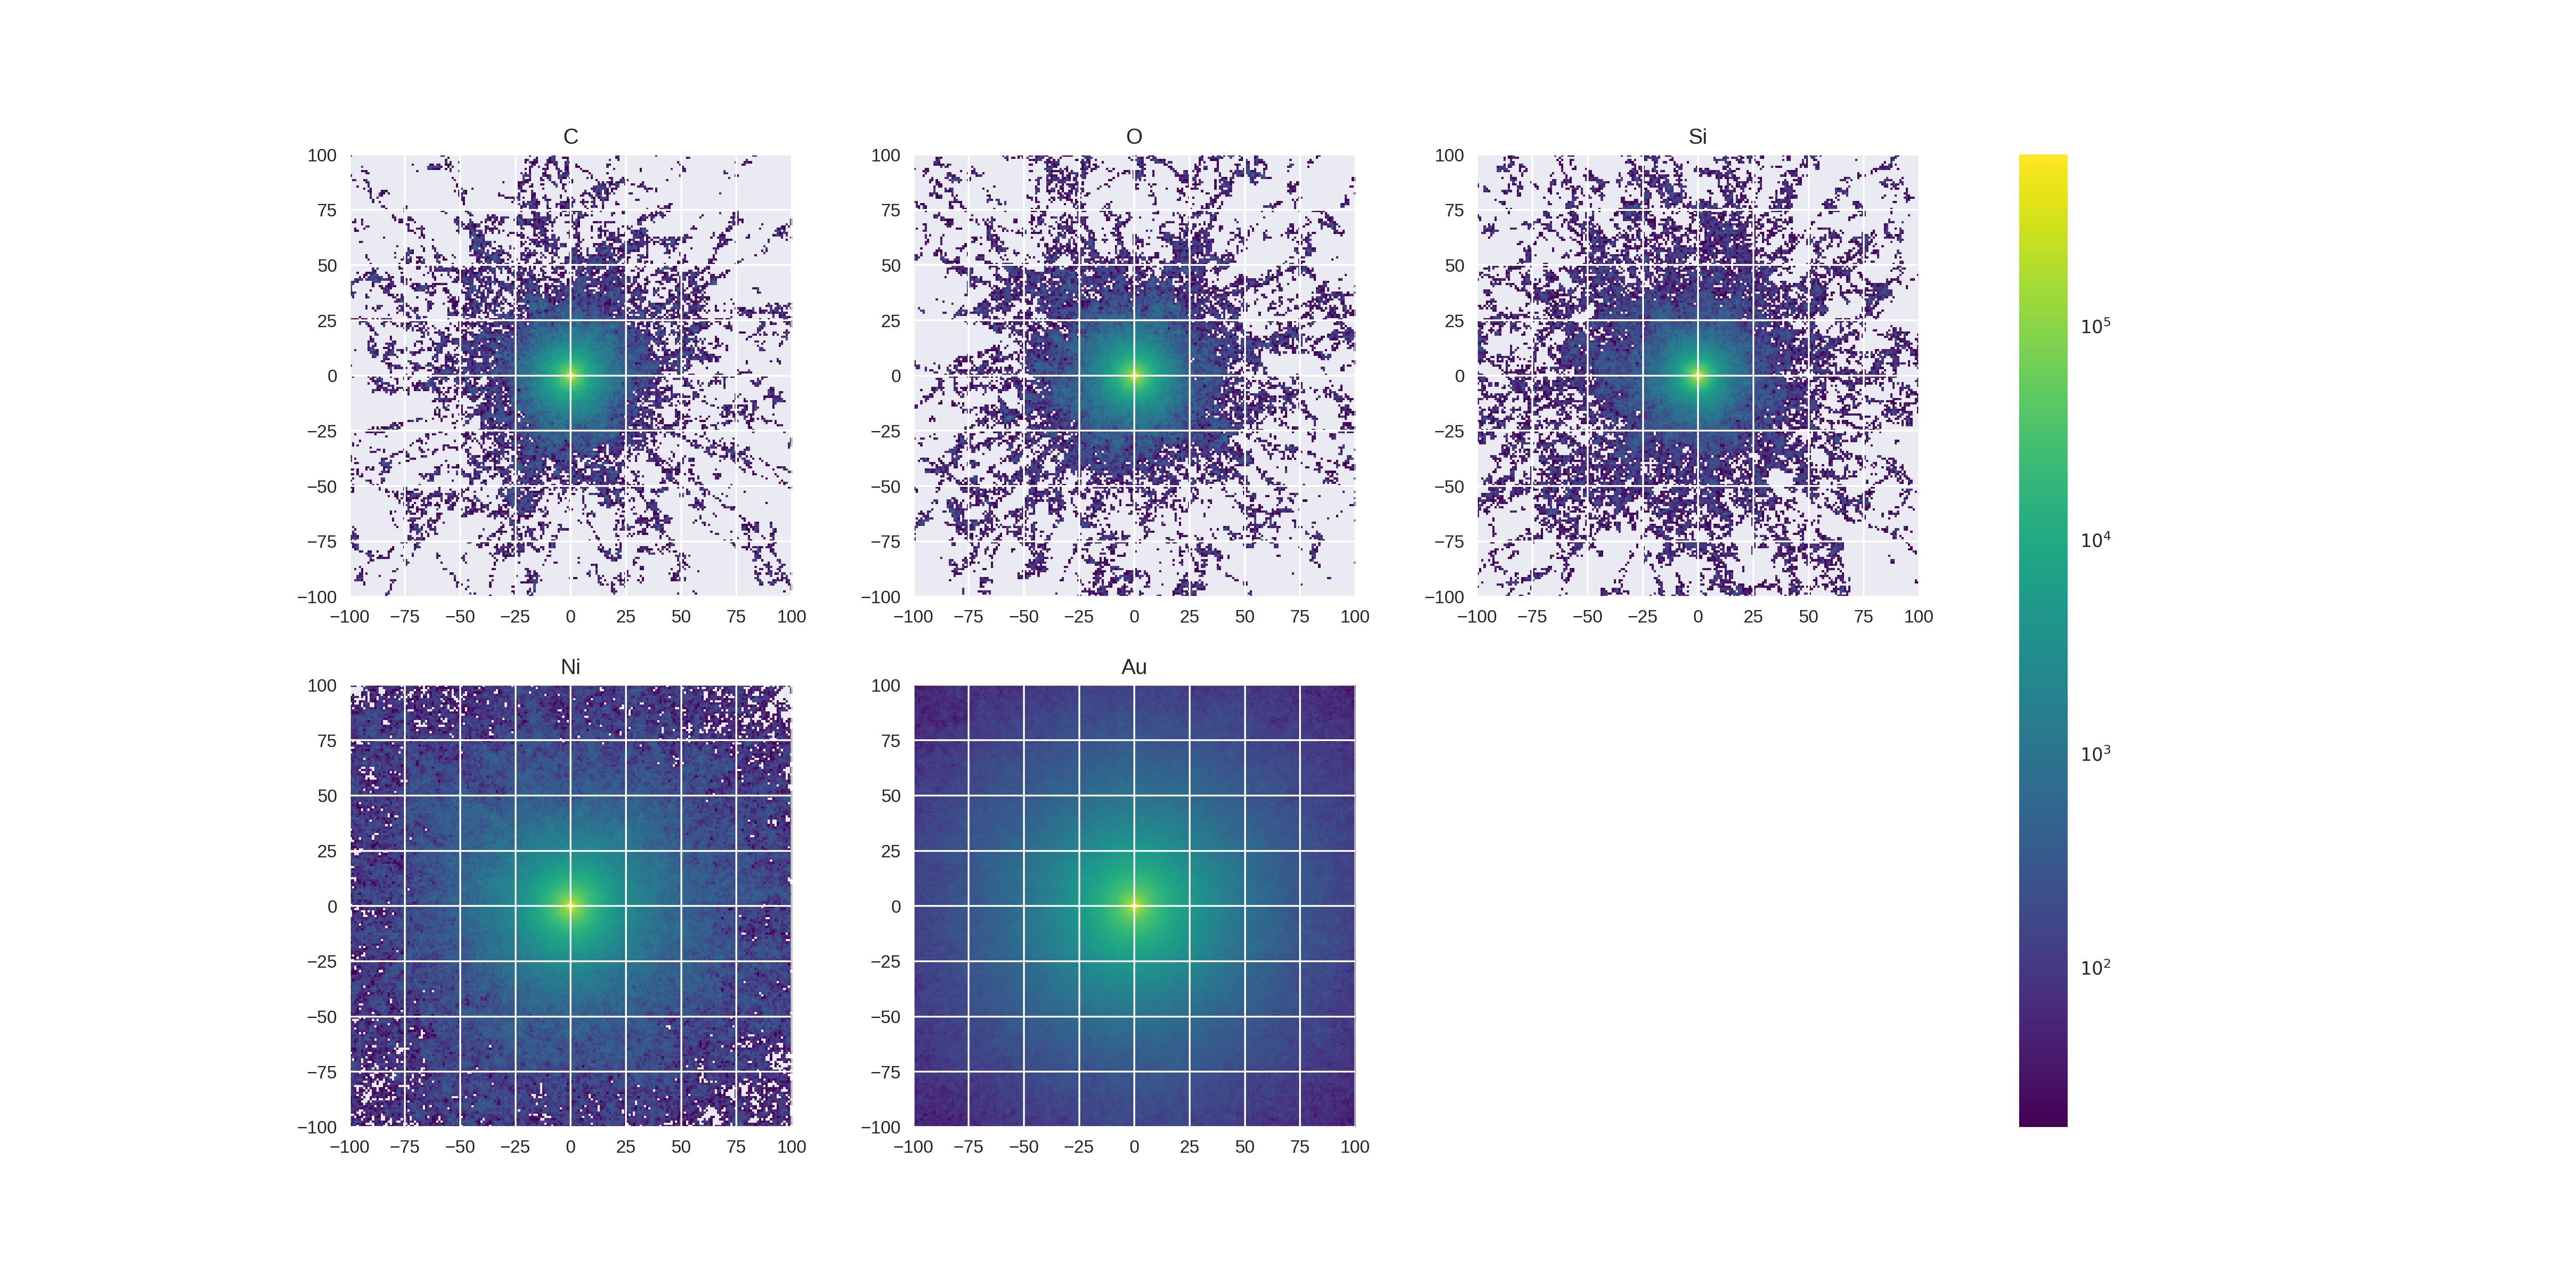

In [12]:
Image(filename=os.path.join(IMAGE_DIRECTORY, 'radial-heatmap-log.png'))

/home/costrouc/.virtualenvs/pysrim-QRHR1eEY/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


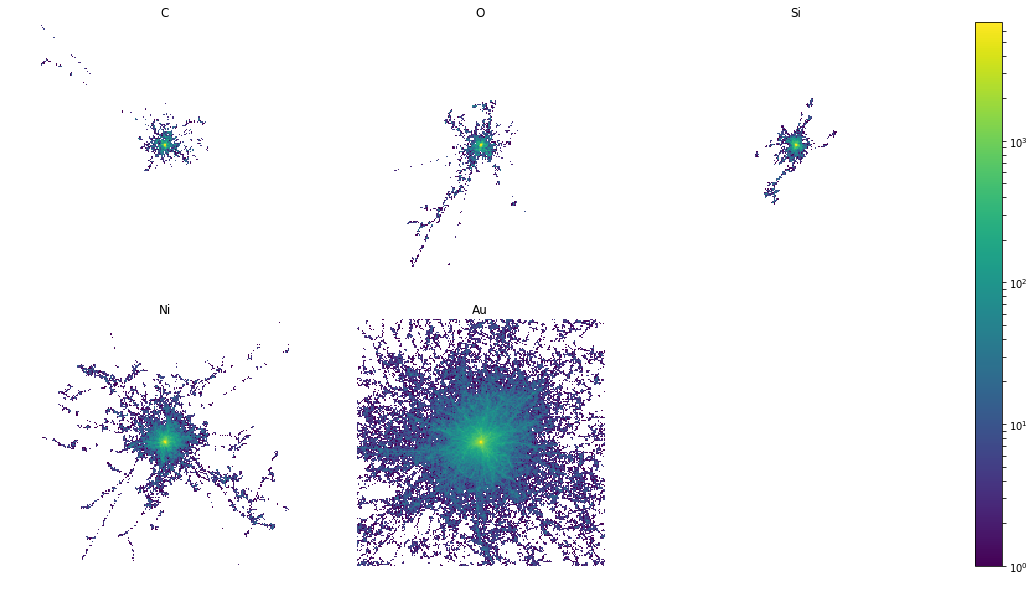

In [13]:
# Using Log color scale
limits = [[-100, 100], [-100, 100]]
bins = (200, 200)

fig, axes = plt.subplots(2, 3)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)
    ax.axis('off')
fig.delaxes(axes[1][2])
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 10)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log-nolabel.png'), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

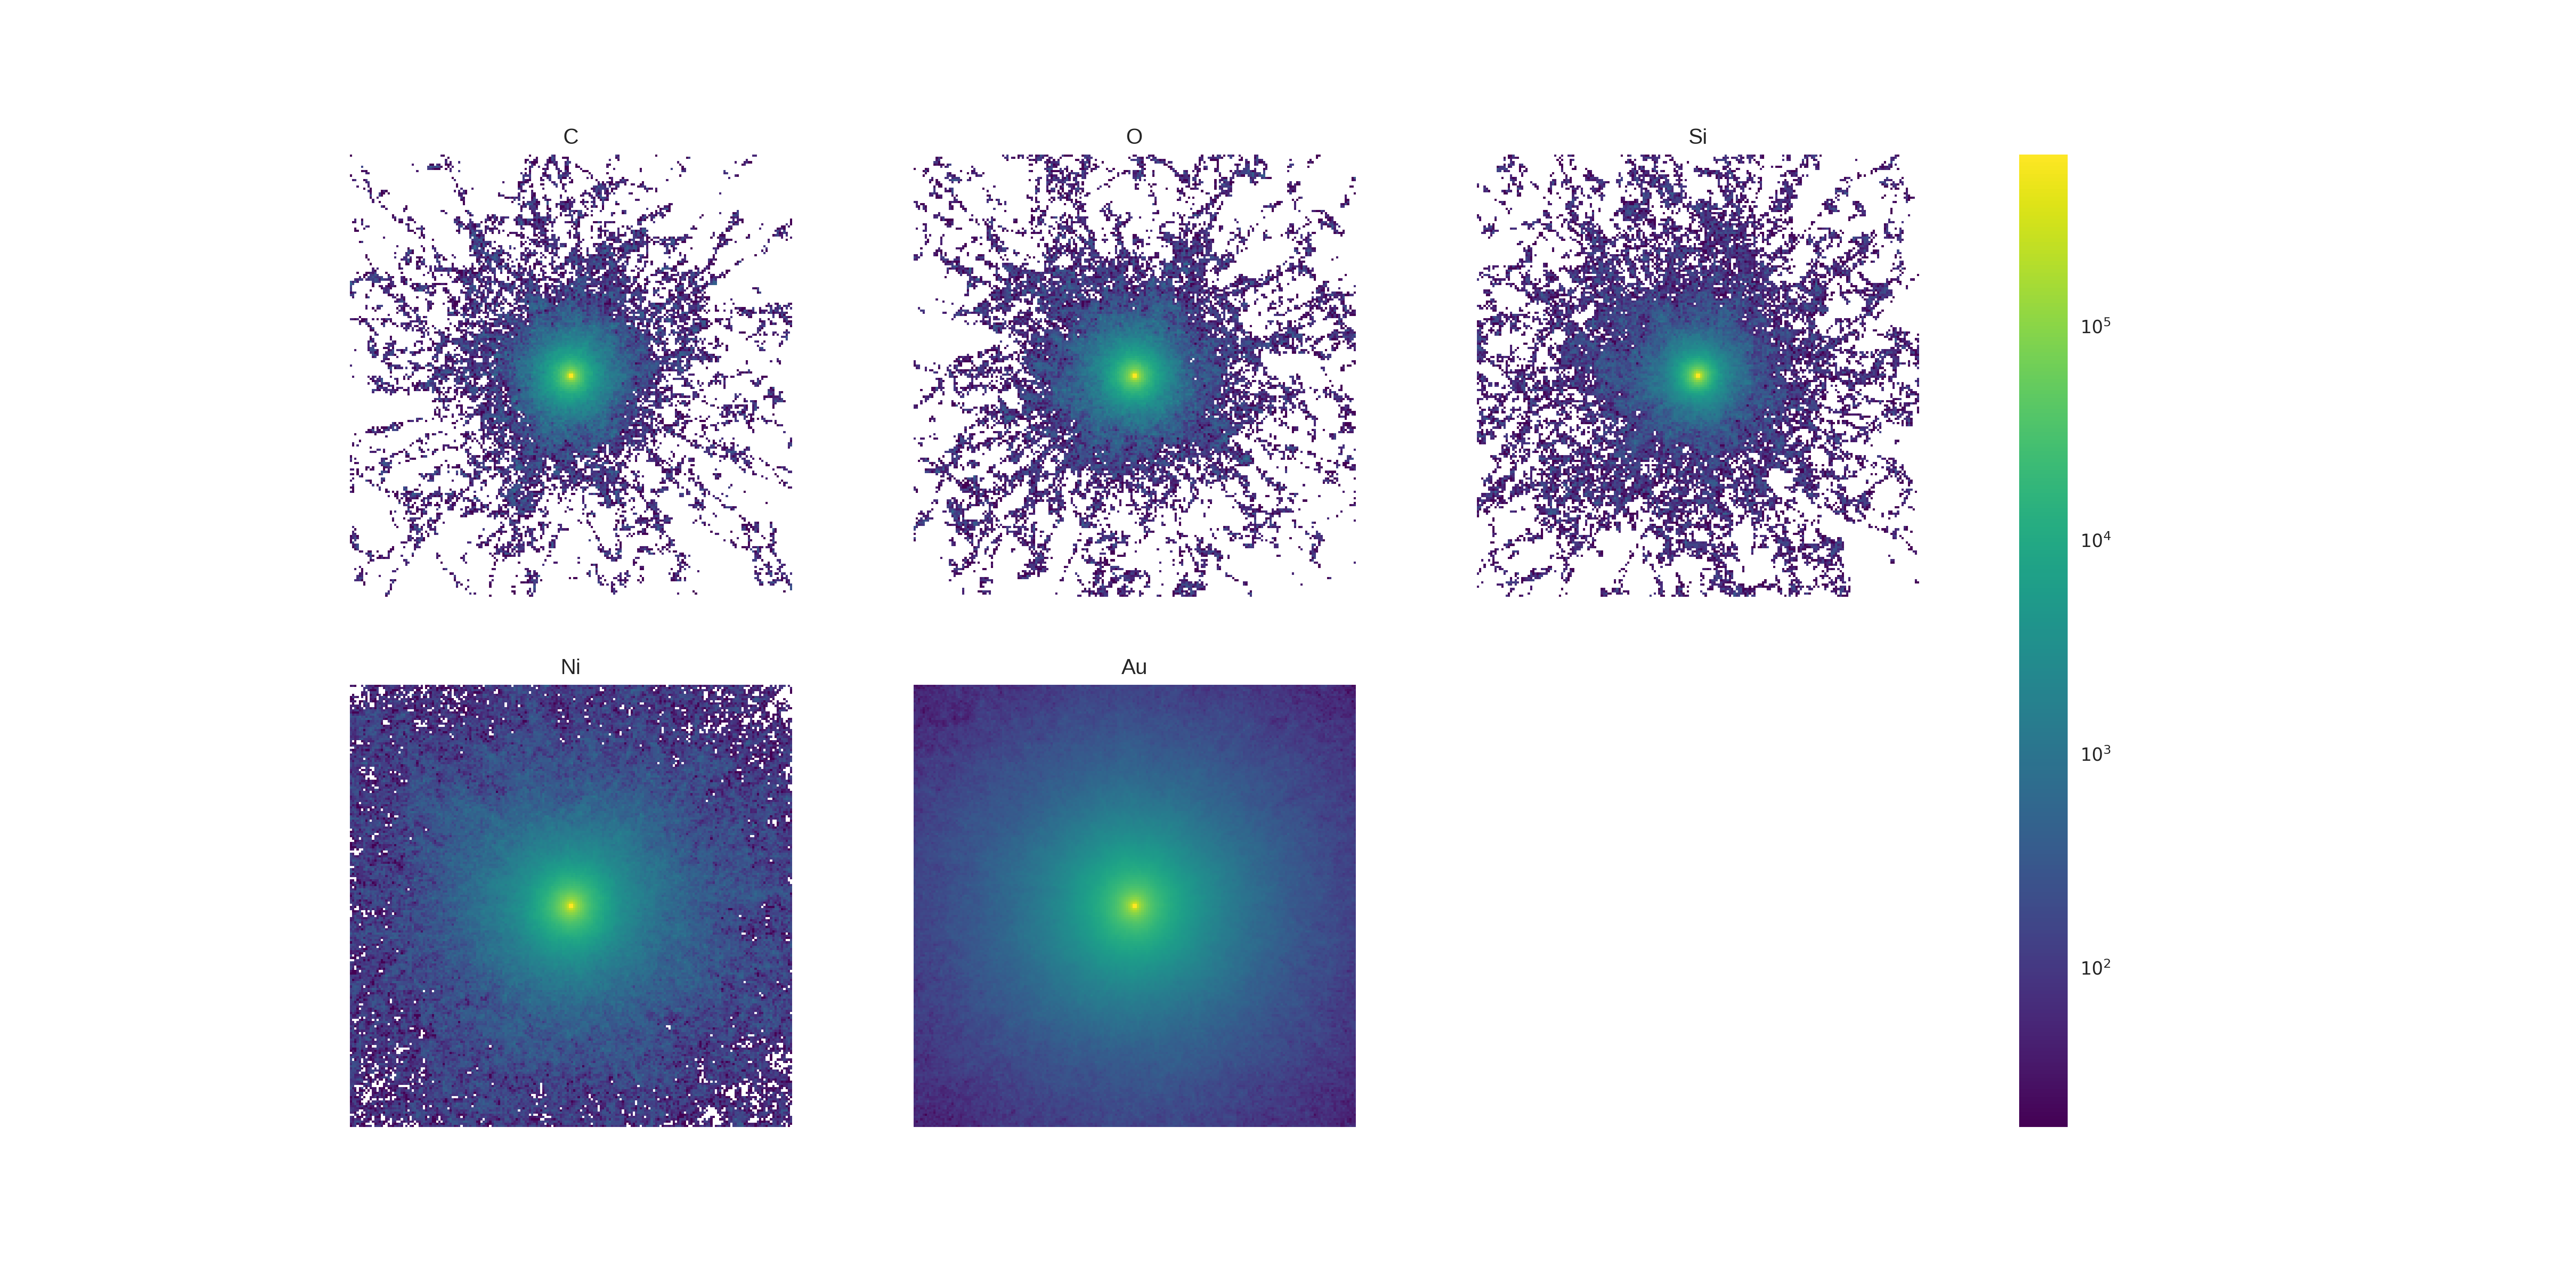

In [14]:
Image(filename=os.path.join(IMAGE_DIRECTORY, 'radial-heatmap-log-nolabel.png'))

/home/costrouc/.virtualenvs/pysrim-QRHR1eEY/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


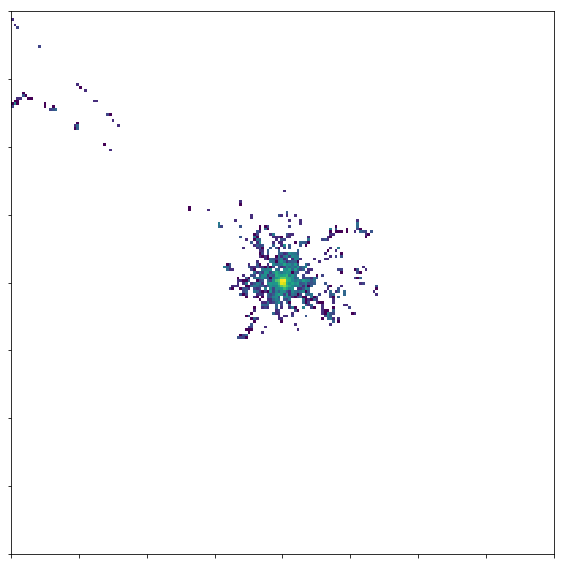

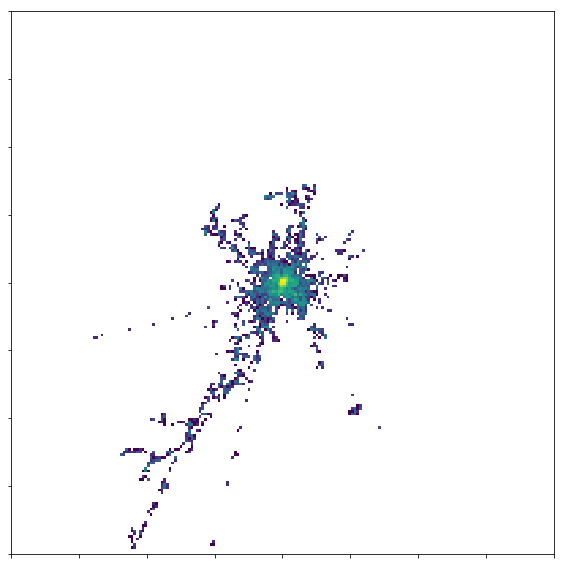

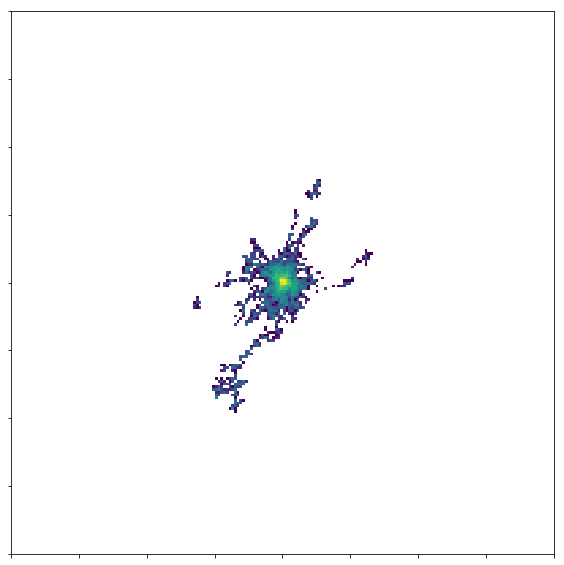

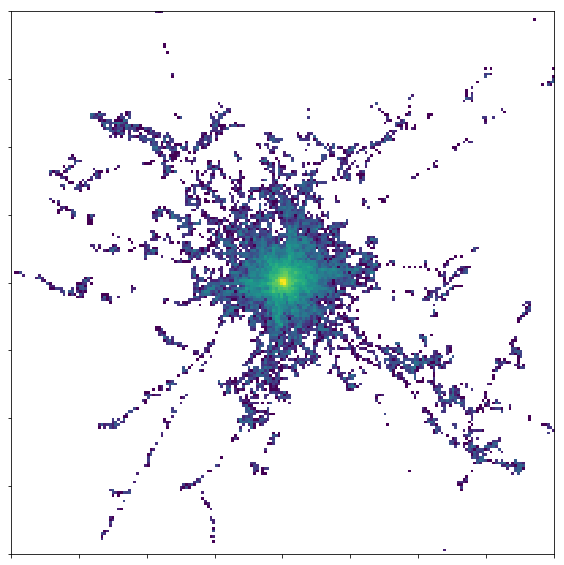

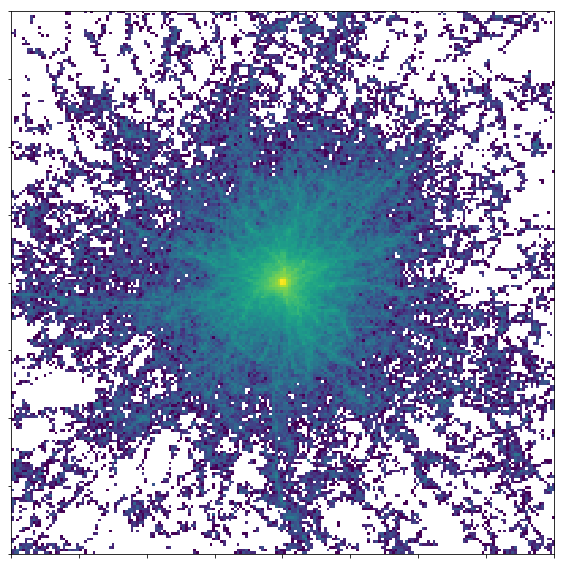

In [15]:
# Using Log color scale - several images
limits = [[-100, 100], [-100, 100]]
bins = (200, 200)

for ion in sorted(data, key=sort_by_mass):
    fig, ax = plt.subplots()
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    # ax.set_title(ion)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.set_size_inches(10, 10)
    fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log-nolabel-%s.png' % ion), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

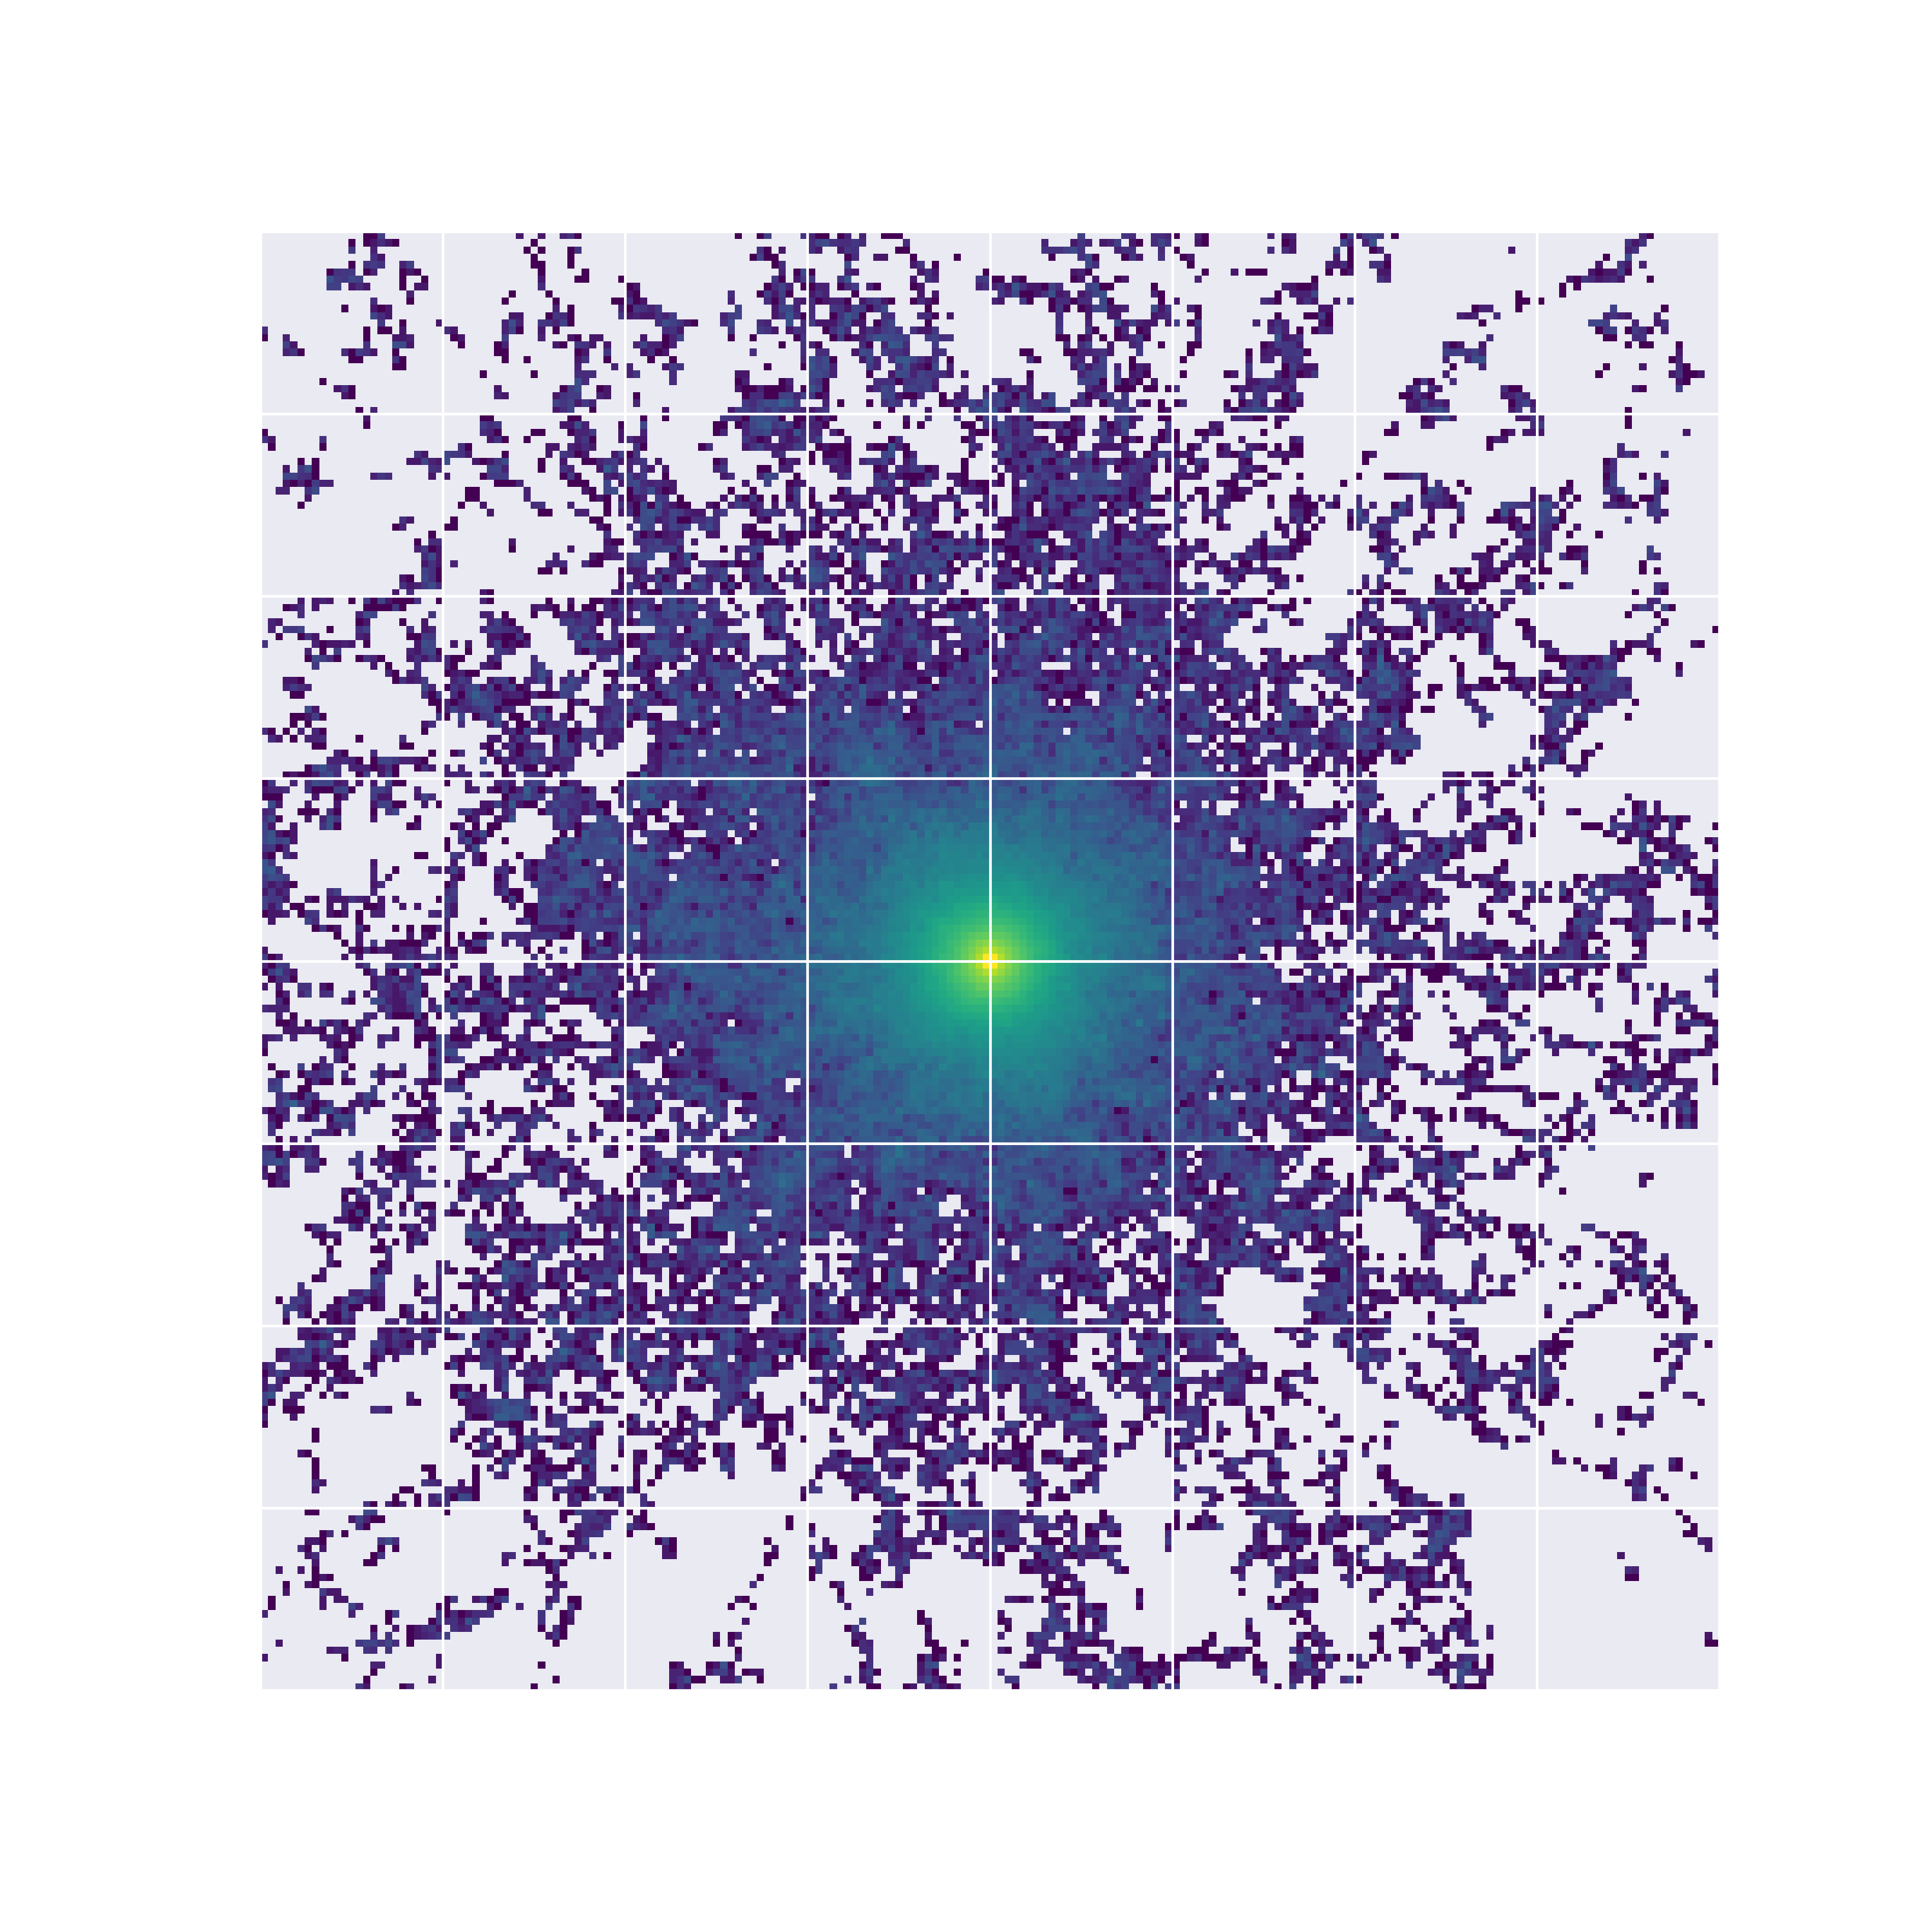

In [16]:
Image(filename=os.path.join(IMAGE_DIRECTORY, 'radial-heatmap-log-nolabel-Si.png'))

In [17]:
# Very small 100 nm (to more clearly show trend)
maximum = 100

fig, ax = plt.subplots()
for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    plot_radial_distribution_hist(ax, radius, maximum, ion)
# ax.set_title('Histogram Radial Distribution (yz) - %.2f [nm]' % maximum)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(2, maximum)
# ax.set_ylim(0, 60000)
ax.legend()
fig.set_size_inches(10, 6)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-hist.png'), transparent=False, dpi=300)

0 C
1 O
2 Si
3 Ni
4 Au


Image from full 10,000 ion calculation.

Was improperly normalized so image is incorrect.

In [18]:
maximum = 100

for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    density, edges = np.histogram(radius, bins=1000, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-8, maximum, len(density))
    with open(os.path.join(IMAGE_DIRECTORY, 'sic-collisions-%s.csv' % ion), 'w') as f:
        f.write('%s radial distance [nm], count [collisions/A^2]\n' % ion)
        for x,y in zip(x, density):
            f.write('{:3.2f},{}\n'.format(x, y))

0 C
1 O
2 Si
3 Ni
4 Au
